* ##### Personal Finance Expense Analysis & Savings Recommendation System
* ##### Name: Barath Anandaraman
* ##### Course: DSC680-T301
* ##### Weeks 8 - 10: Milestone 2
* ##### Date: 08/02/2025

---

#### Load necessary packages

In [1]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### Load data

In [2]:
file_path = "synthetic_personal_finance_dataset.csv"
df = pd.read_csv(file_path)

#### Display basic information about the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32424 entries, 0 to 32423
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  32424 non-null  object 
 1   age                      32424 non-null  int64  
 2   gender                   32424 non-null  object 
 3   education_level          32424 non-null  object 
 4   employment_status        32424 non-null  object 
 5   job_title                32424 non-null  object 
 6   monthly_income_usd       32424 non-null  float64
 7   monthly_expenses_usd     32424 non-null  float64
 8   savings_usd              32424 non-null  float64
 9   has_loan                 32424 non-null  object 
 10  loan_type                12995 non-null  object 
 11  loan_amount_usd          32424 non-null  float64
 12  loan_term_months         32424 non-null  int64  
 13  monthly_emi_usd          32424 non-null  float64
 14  loan_interest_rate_pct

In [4]:
print(df.head())

  user_id  age  gender education_level employment_status    job_title  \
0  U00001   56  Female     High School     Self-employed  Salesperson   
1  U00002   19  Female             PhD          Employed  Salesperson   
2  U00003   20  Female          Master          Employed      Teacher   
3  U00004   25    Male             PhD          Employed      Manager   
4  U00005   53  Female             PhD          Employed      Student   

   monthly_income_usd  monthly_expenses_usd  savings_usd has_loan  loan_type  \
0             3531.69               1182.59    367655.03       No        NaN   
1             3531.73               2367.99    260869.10      Yes  Education   
2             2799.49               1003.91    230921.21       No        NaN   
3             5894.88               4440.12    304815.51      Yes   Business   
4             5128.93               4137.61    461509.48       No        NaN   

   loan_amount_usd  loan_term_months  monthly_emi_usd  loan_interest_rate_pct  \

##### Based on the dataset info, there are no null rows

#### Perform Feature Engineering

In [5]:
df['disposable_income_usd'] = df['monthly_income_usd'] - df['monthly_expenses_usd']
df['expense_to_income_ratio'] = df['monthly_expenses_usd'] / df['monthly_income_usd']
df['savings_to_income_ratio'] = df['savings_usd'] / df['monthly_income_usd']
df['loan_to_income_ratio'] = df['loan_amount_usd'] / df['monthly_income_usd']
df['emi_to_income_ratio'] = df['monthly_emi_usd'] / df['monthly_income_usd']

In [6]:
# Perform Age Group Binning

def age_group(age):
    if age < 30:
        return 'Young Adult'
    elif 30 <= age < 50:
        return 'Middle-Aged'
    else:
        return 'Senior'
df['age_group'] = df['age'].apply(age_group)

#### Plot boxplots to visualize outliers

In [7]:
# Select columns for outlier detection
numerical_cols = ['monthly_income_usd', 'monthly_expenses_usd', 'savings_usd', 'loan_amount_usd', 
                  'monthly_emi_usd', 'debt_to_income_ratio', 'disposable_income_usd', 'savings_to_income_ratio', 
                  'expense_to_income_ratio', 'loan_to_income_ratio', 'emi_to_income_ratio']

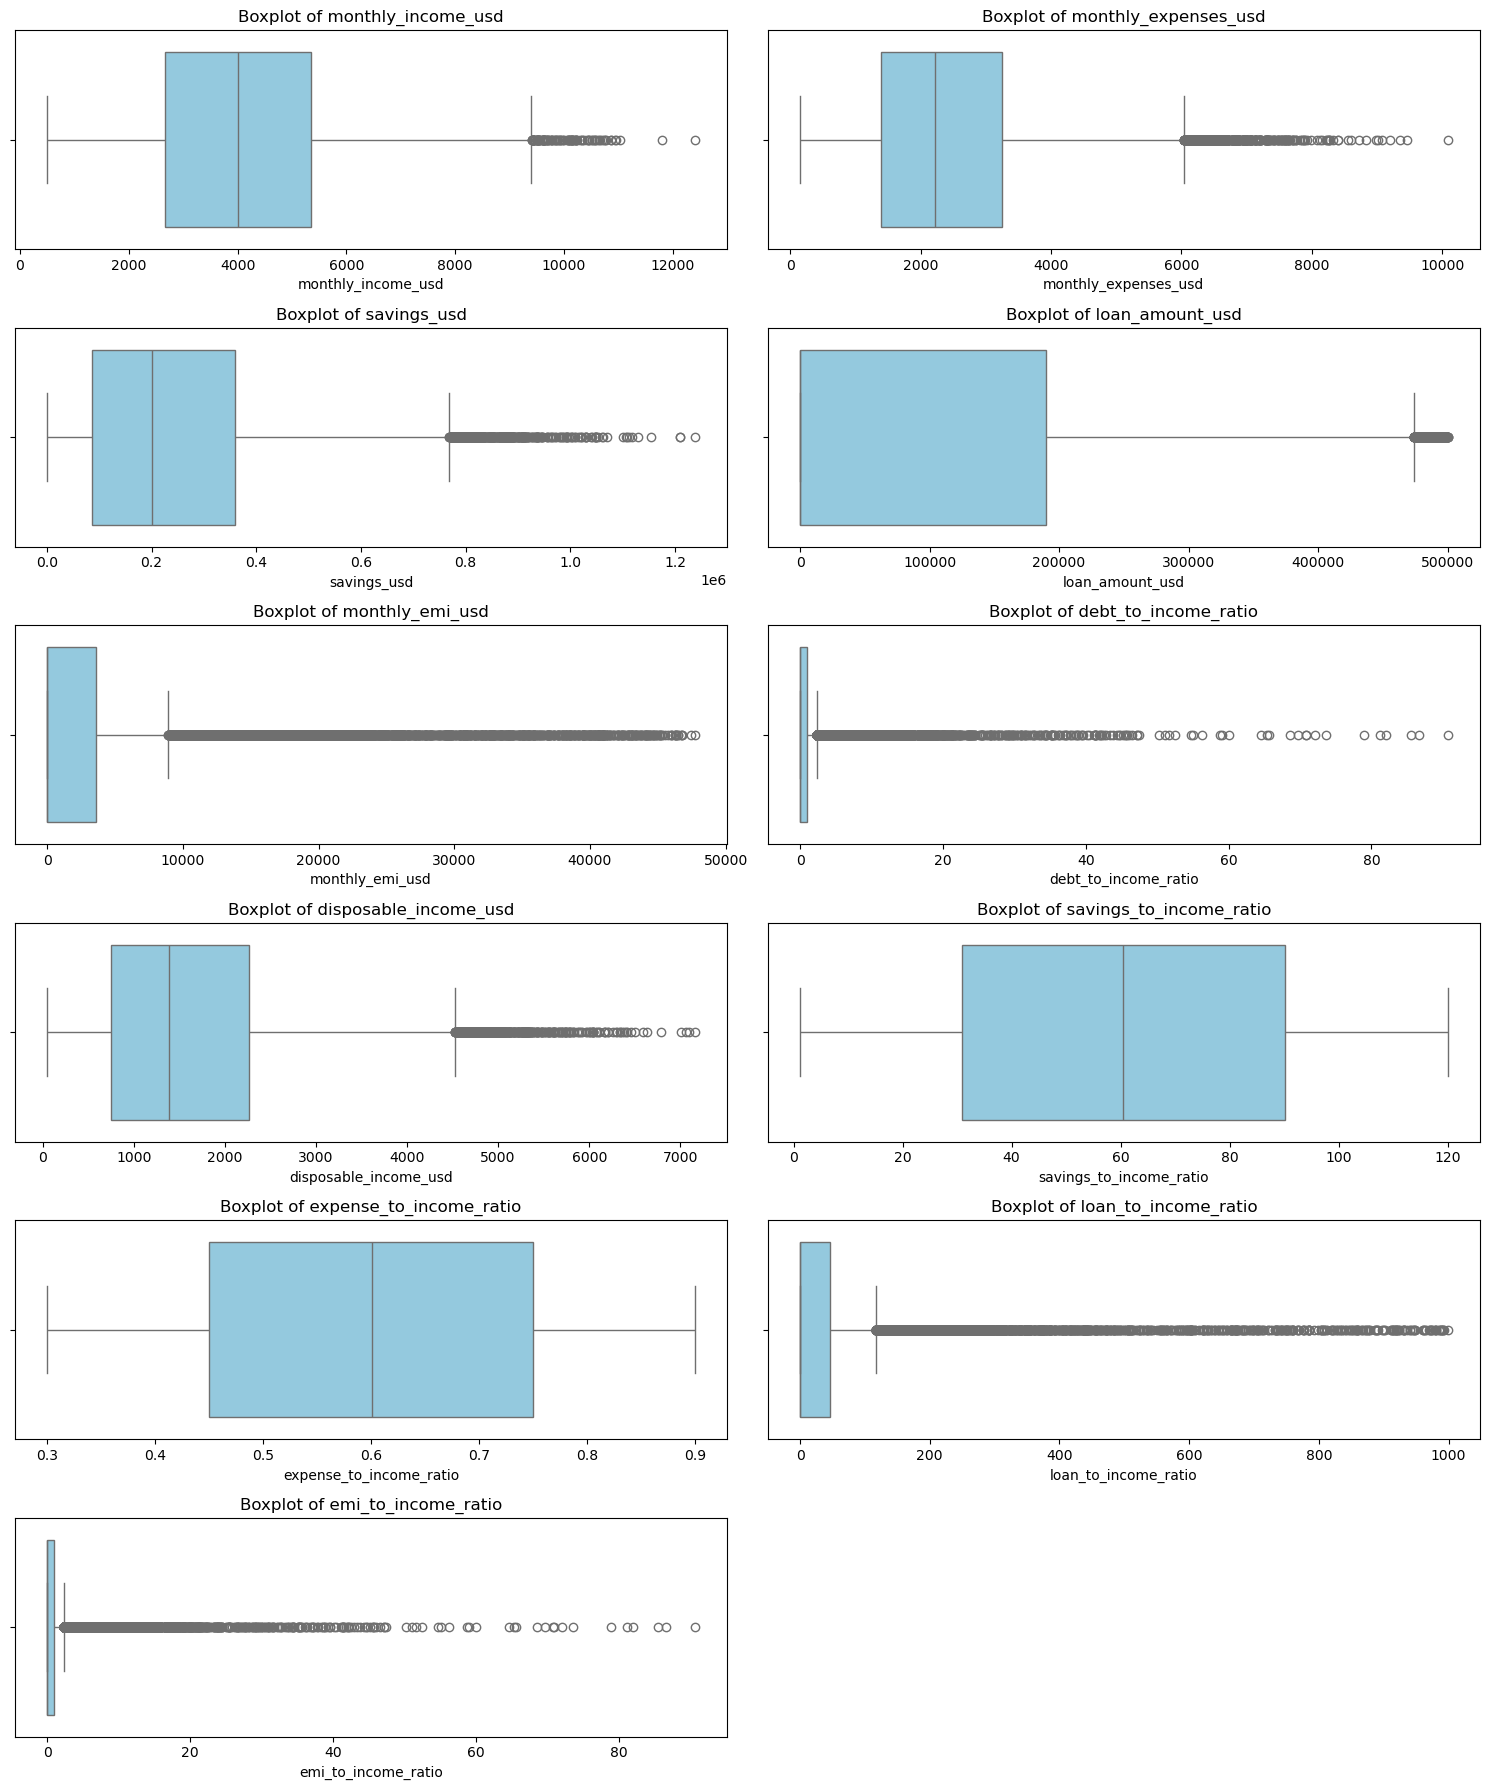

In [8]:
# Plot boxplots to visualize outliers
plt.figure(figsize=(15, 18))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(6,2,i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

##### The box plots clearly reveal significant outliers in several financial features like loan_to_income_ration, emi_to_income_ratio, disposable_income_usd, debt_to_income_ratio, monthly_emi_usd, monthly_expenses_usd

#### Histograms on the features

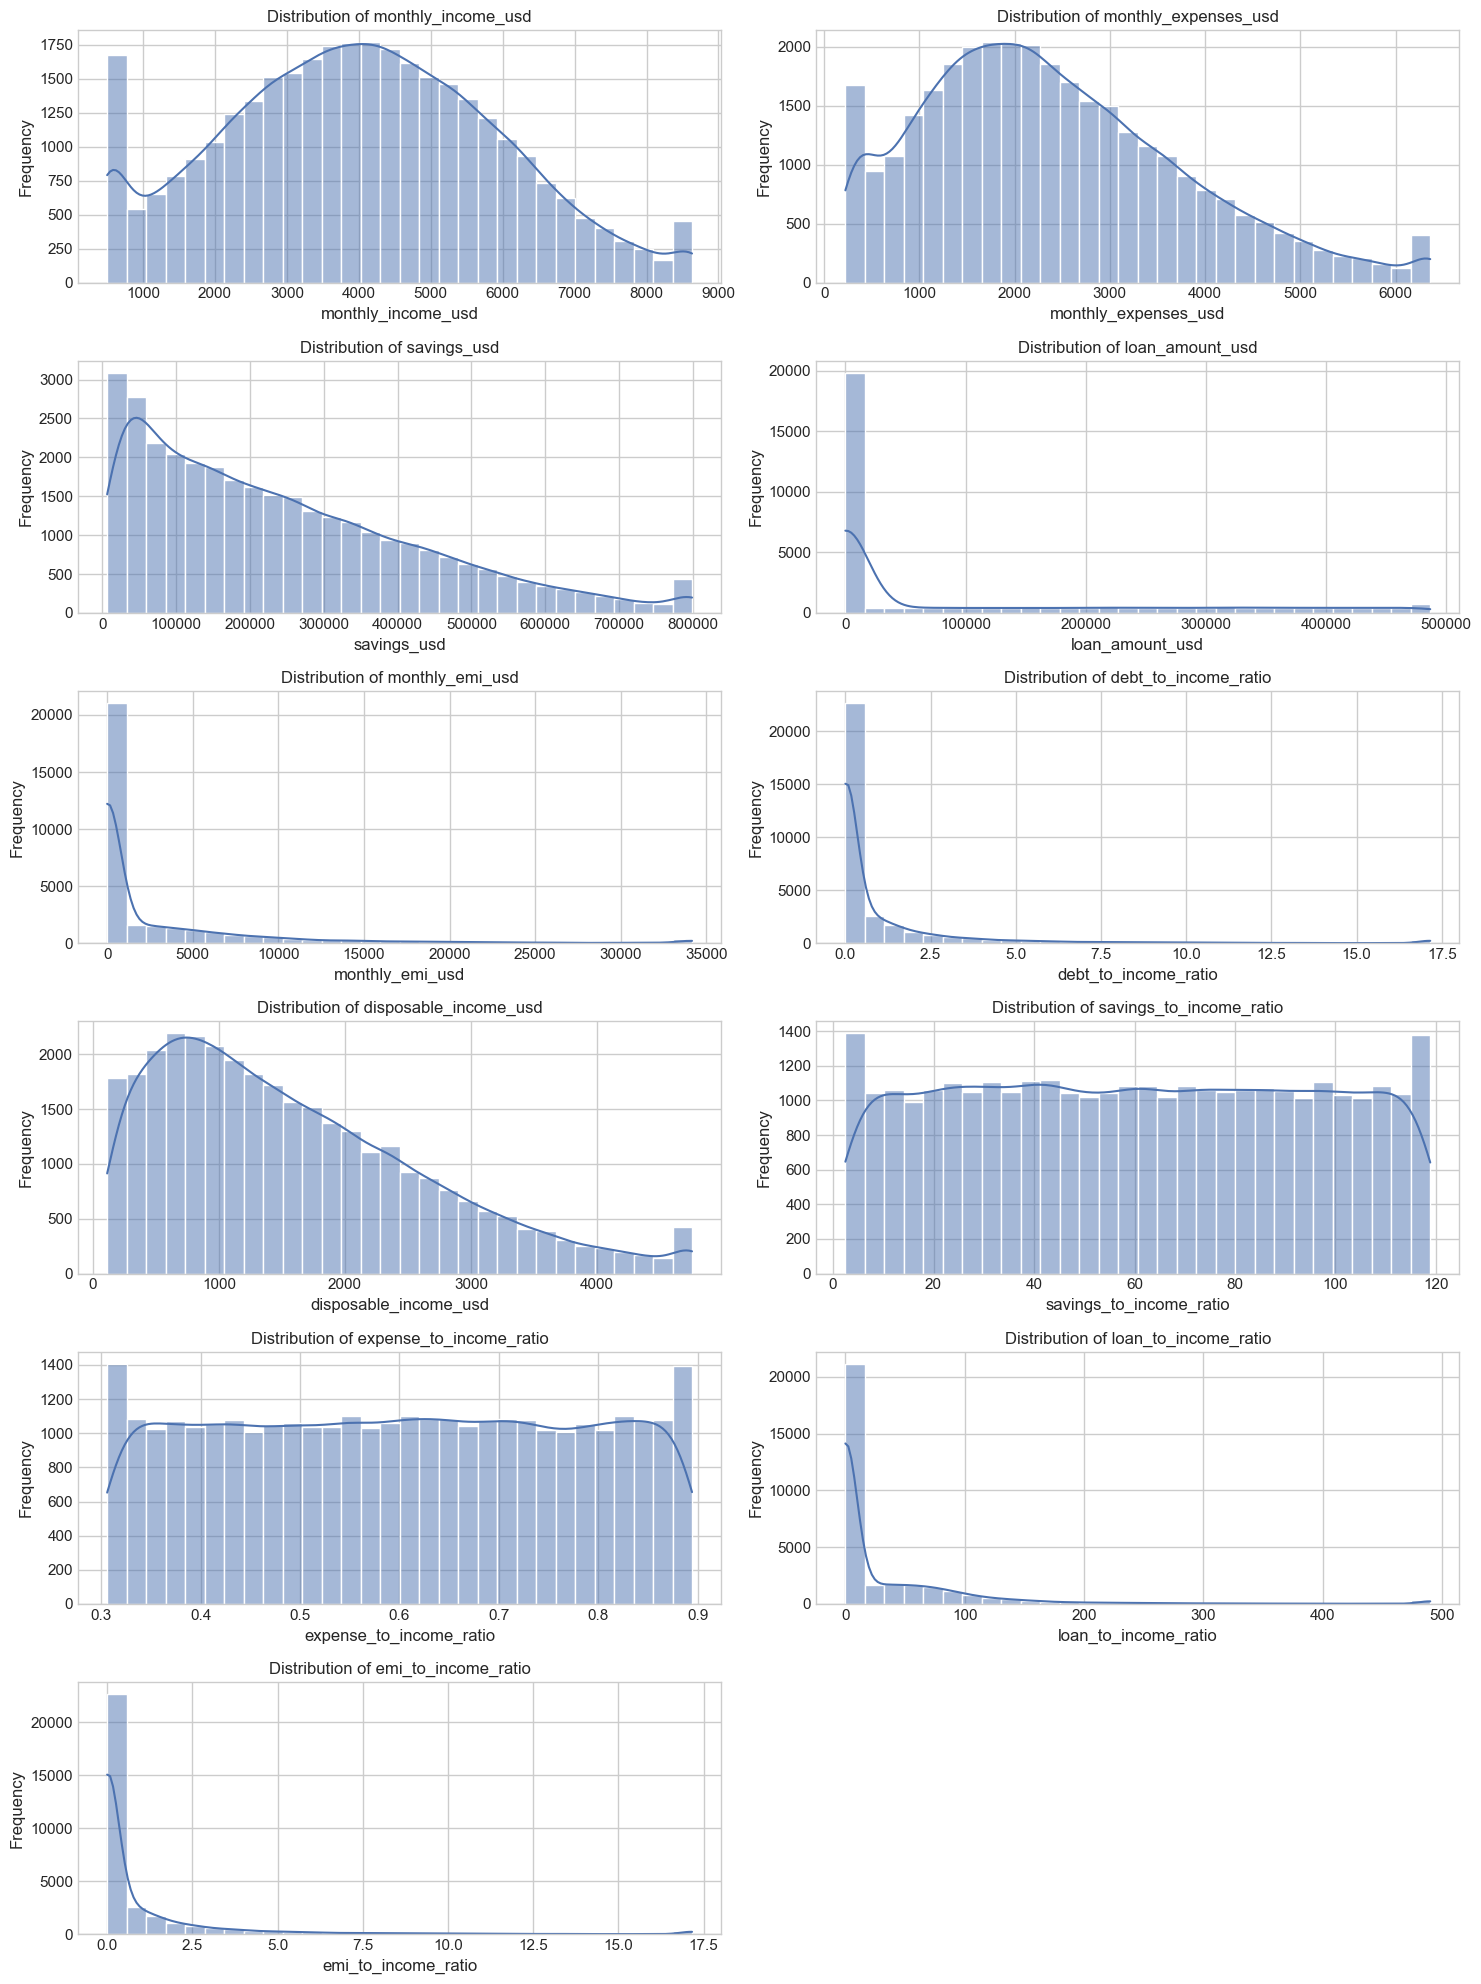

In [20]:
# Univariate Analysis - Histograms
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 20))
axes = axes.flatten()

for i, feature in enumerate(numerical_cols):
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

axes[-1].axis('off')  # Hide the last subplot
plt.tight_layout()
plt.show()


#### Scatter plot

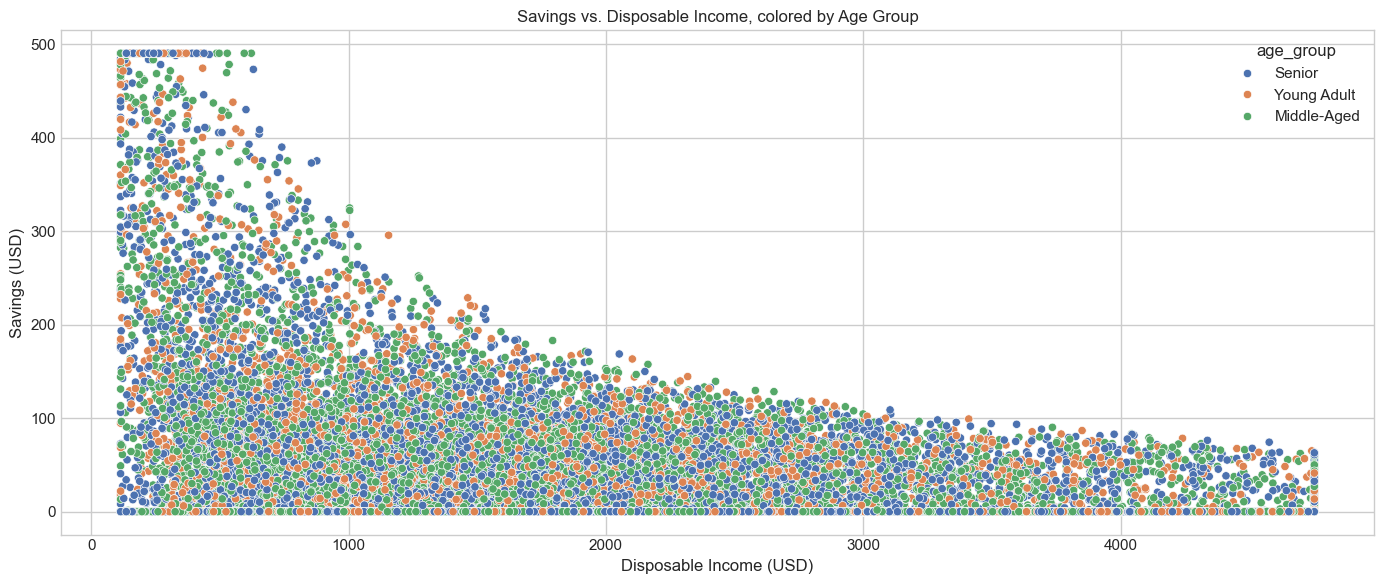

In [28]:
plt.figure(figsize=(14, 6))
sns.scatterplot(data=df, x='disposable_income_usd', y='loan_to_income_ratio', hue='age_group')
plt.title('Savings vs. Disposable Income, colored by Age Group')
plt.xlabel('Disposable Income (USD)')
plt.ylabel('Savings (USD)')
plt.tight_layout()
plt.show()

#### Perform Correlation matrix

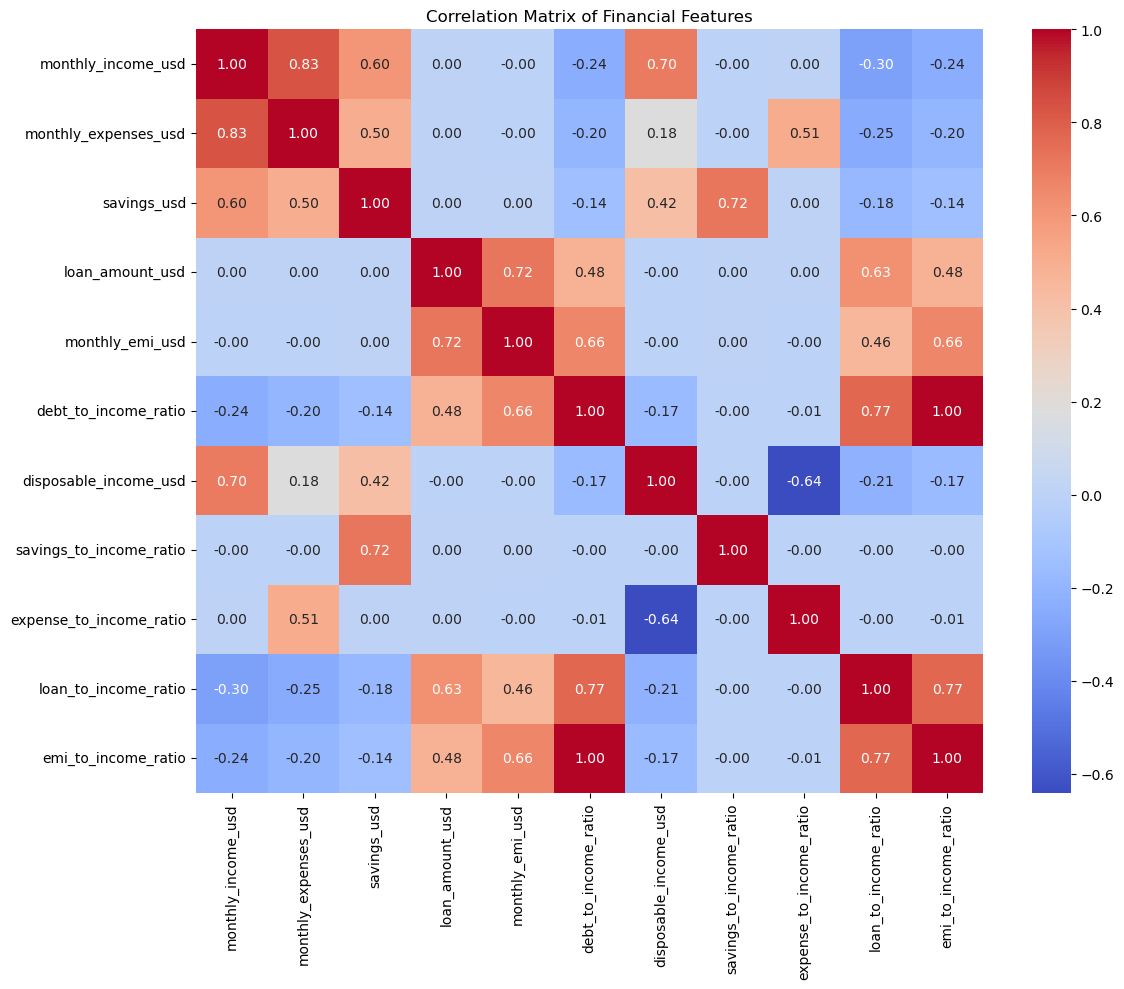

In [9]:
# Define the features for analysis
features_for_analysis = [
        'monthly_income_usd', 'monthly_expenses_usd', 'savings_usd', 'loan_amount_usd', 
        'monthly_emi_usd', 'debt_to_income_ratio', 'disposable_income_usd', 'savings_to_income_ratio', 
        'expense_to_income_ratio', 'loan_to_income_ratio', 'emi_to_income_ratio'
]

# Bi/Multivariate Analysis - Correlation Matrix 
correlation_matrix = df[features_for_analysis].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Financial Features')
plt.tight_layout()
plt.show()

#### Winsorize outliers at upper/lower IQR thresholds to preserve data size

In [10]:
# Winsorization
for col in numerical_cols:
    df[col] = winsorize(df[col], limits=[0.01, 0.01])

##### Numerical features have been successfully winsorized, capping the extreme top and bottom 1% values to reduce the influence of outliers without removing the data

#### Perform standardization for clustering

In [11]:
# Standardization 
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols)

#### Elbow Method to find the optimal number of clusters

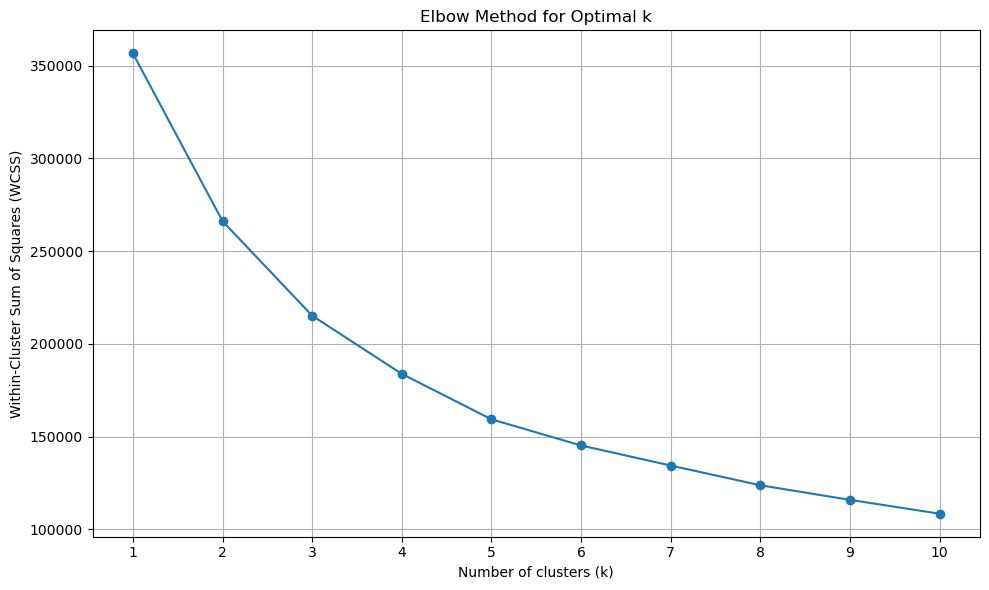

In [12]:
wcss = []
k_range = range(1, 11)
for i in k_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_range)
plt.grid(True)
plt.tight_layout()
plt.show()


##### Based on Elbow method the optimal number of clusters is 4

#### Perform Kmeans clustering

In [13]:
# Clustering
kmeans_final = KMeans(n_clusters=4, init='k-means++', random_state=42)
cluster_labels = kmeans_final.fit_predict(scaled_df)
df['cluster'] = cluster_labels

#### Cluster Profiling

In [14]:
cluster_profile = df.groupby('cluster')[
    ['monthly_income_usd', 'monthly_expenses_usd', 'savings_usd',
     'loan_amount_usd', 'monthly_emi_usd', 'debt_to_income_ratio',
     'disposable_income_usd', 'expense_to_income_ratio',
     'savings_to_income_ratio', 'loan_to_income_ratio',
     'emi_to_income_ratio']
].mean().round(2)
print(cluster_profile)


         monthly_income_usd  monthly_expenses_usd  savings_usd  \
cluster                                                          
0                   5347.90               2365.48    344802.85   
1                   5371.53               4052.38    354127.97   
2                   2524.15               1530.24    118159.23   
3                   2526.58               1521.91    145955.77   

         loan_amount_usd  monthly_emi_usd  debt_to_income_ratio  \
cluster                                                           
0               93645.81          2253.42                  0.44   
1               99826.59          2312.57                  0.45   
2               40025.30           770.49                  0.32   
3              358104.99         16290.47                  7.60   

         disposable_income_usd  expense_to_income_ratio  \
cluster                                                   
0                      2973.81                     0.44   
1                      

#### Model Evaluation Metrics

In [15]:
silhouette = silhouette_score(scaled_df, cluster_labels)
davies_bouldin = davies_bouldin_score(scaled_df, cluster_labels)
wcss = kmeans.inertia_

print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"WCSS: {wcss:.2f}")


Silhouette Score: 0.2189
Davies-Bouldin Index: 1.3896
WCSS: 108406.85


#### Qualitative Assessment: Visualize some features across clusters

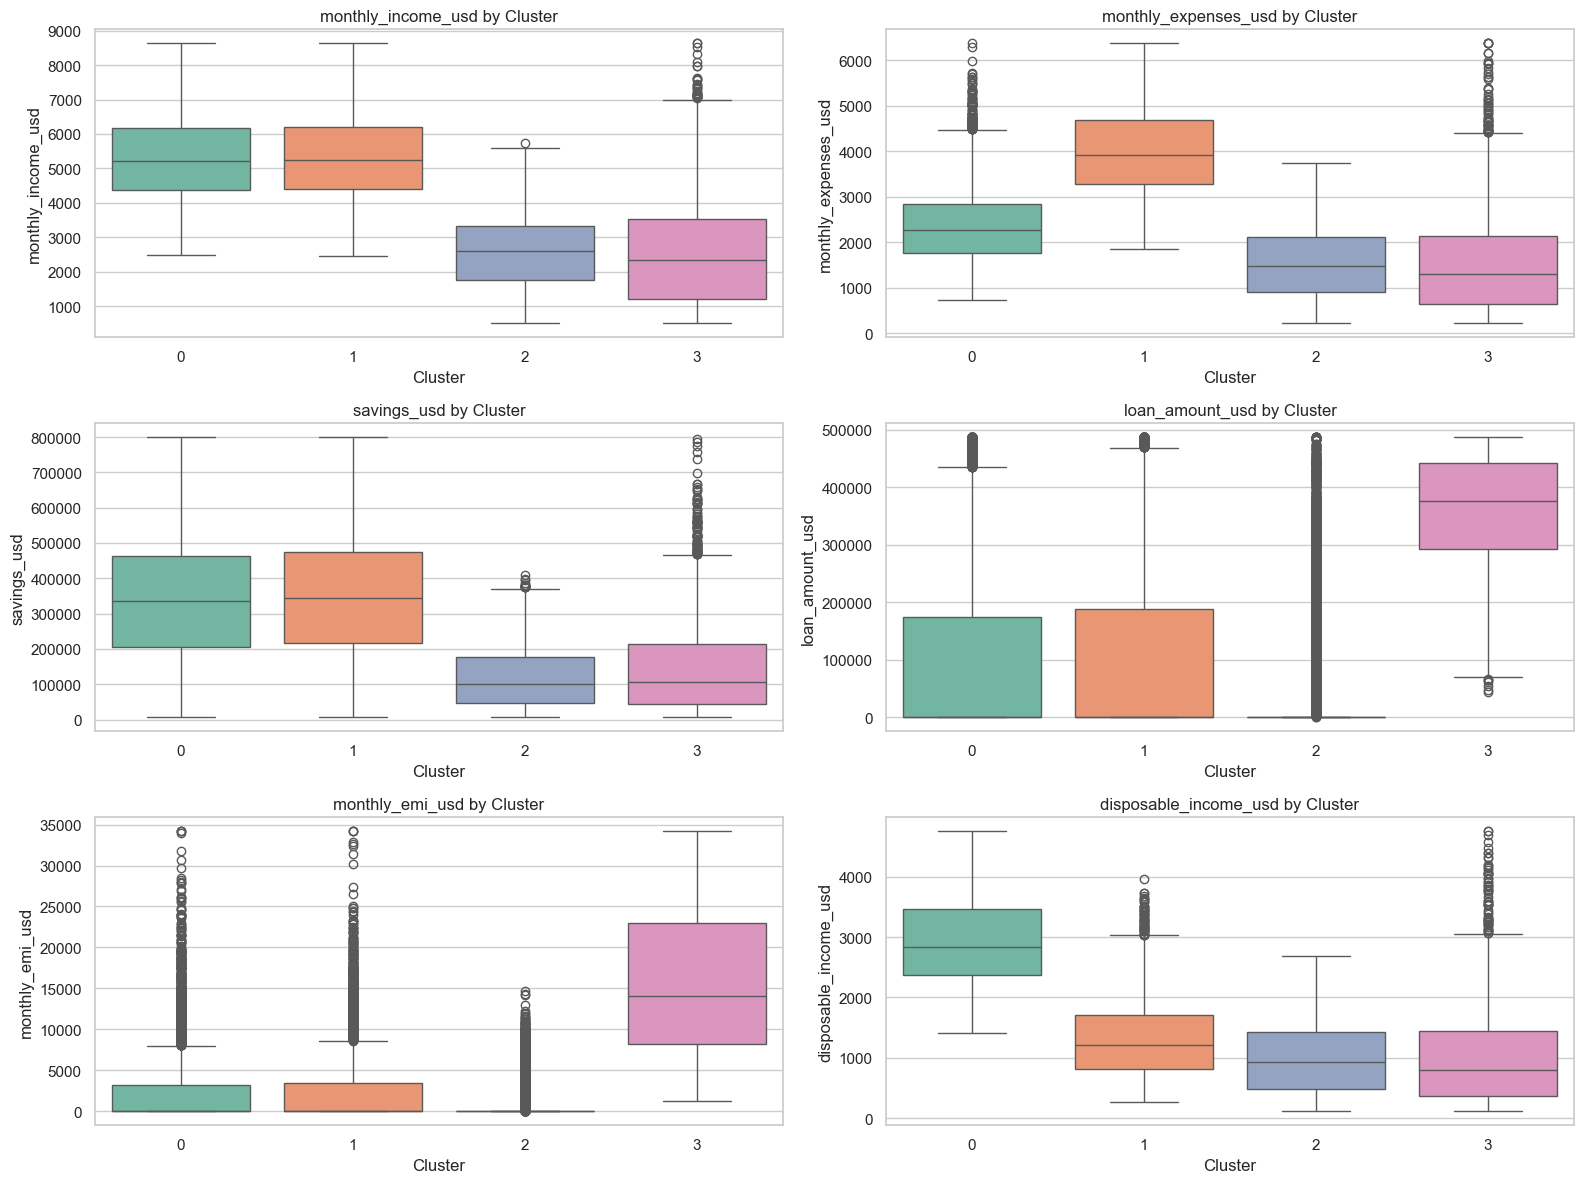

In [16]:
# Box Plots
sns.set(style='whitegrid')
boxplot_features = ['monthly_income_usd', 'monthly_expenses_usd', 'savings_usd',
                    'loan_amount_usd', 'monthly_emi_usd', 'disposable_income_usd']
plt.figure(figsize=(16, 12))
for i, feature in enumerate(boxplot_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='cluster', y=feature, data=df, palette='Set2')
    plt.title(f'{feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()


---

***Box Plot Analysis- Distributions by Cluster:***
1. Monthly_income_usd
- Cluster 0 and 1 have higher median income.
- Cluster 2 has lowest median with a tight IQR (less income variance).
2. monthly_expenses_usd
- Cluster 1 and 3 spend more.
- Cluster 0 maintains lower median expenses despite high income (savings).
- Cluster 2 spends the least, likely due to limited income.
3. savings_usd
- Cluster 0. And 1 save more.
- Cluster 2 and 3 show limited savings.
4. loan_amount_usd & monthly_emi_usd
- Cluster 3 is heavily burdened by loans and EMI.
- Cluster 2 and 0 have minimal to zero loans.
5. disposable_income_usd
- Cluster 0 leads with high surplus.
- Cluster 1 is moderate.
- Clusters 2 and 3 show low to moderate surplus.


---

#### Radar Chart

In [32]:
normalized_means.iloc[2]

monthly_income_usd       0.000000
monthly_expenses_usd     0.003291
savings_usd              0.000000
loan_amount_usd          0.000000
monthly_emi_usd          0.000000
disposable_income_usd    0.000000
Name: 2, dtype: float64

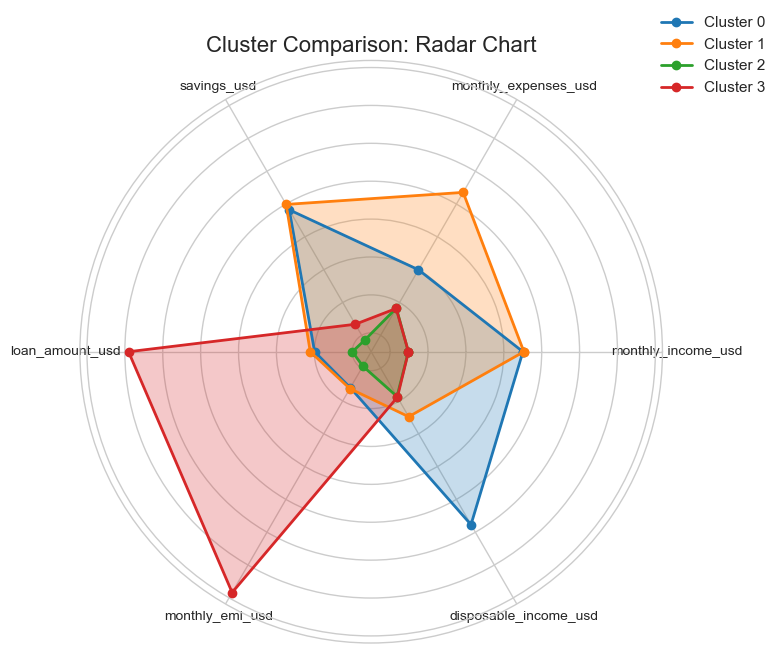

In [35]:
# Radar Chart
radar_features = ['monthly_income_usd', 'monthly_expenses_usd', 'savings_usd',
                  'loan_amount_usd', 'monthly_emi_usd', 'disposable_income_usd']
cluster_means = df.groupby('cluster')[radar_features].mean()
#normalized_means = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
# Z-Score standardization as cluster 2 is too small for data visualization
normalized_means = (cluster_means - cluster_means.mean()) / (cluster_means.max() - cluster_means.std())
normalized_means = normalized_means.sort_index()
labels = radar_features
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
#for i, row in normalized_means.iterrows():
for i in range(normalized_means.shape[0]):
    #values = row.tolist() + [row.tolist()[0]]
    #ax.plot(angles, values, label=f'Cluster {i}', color=colors[i])
    #ax.fill(angles, values, alpha=0.25, color=colors[i])
    row = normalized_means.iloc[i]
    values = row.tolist() + [row.tolist()[0]]
    ax.plot(angles, values, label=f'Cluster {normalized_means.index[i]}', color=colors[i], linewidth=2, marker='o')
    ax.fill(angles, values, alpha=0.25, color=colors[i])

ax.set_title("Cluster Comparison: Radar Chart", size=16)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_yticklabels([])
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()


---

Radar chart showing normalized cluster profiles across 6 financial indicators.
1. Cluster 0 (Blue): “High Earners, High Surplus”
- High on monthly_income_usd and disposable_income_usd.
- Moderate savings and low debt.
- Financially healthy with significant surplus.
- ***Recommendation***: Consider long-term investment, retirement optimization, or diversification into real estate or stocks.
2. Cluster 1 (Orange): “Stable Mid-Income, Moderate Expense & Savings”
- Balanced profile: medium income, expenses, and savings.
- Slightly better than average across most metrics, but not dominant.
- ***Recommendation***: Continue current financial strategy, start automating savings and optimize for tax benefits.
3. Cluster 2 (Green): “Financially Vulnerable”
- Low across all metrics: income, savings, surplus, and debt.
- Likely young earners or underemployed individuals.
- ***Recommendation***: Focus on income growth (upskilling), expense minimization, and building an emergency fund.
4. Cluster 3 (Red): “High Debt Load with High EMI”
- Dominant in loan_amount_usd and monthly_emi_usd.
- Income is relatively low, savings are modest.
- Disposable income is limited, indicating financial stress.
- ***Recommendation***: Debt consolidation, refinancing, or income support programs. Avoid further debt burden.
